C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3_64bit\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

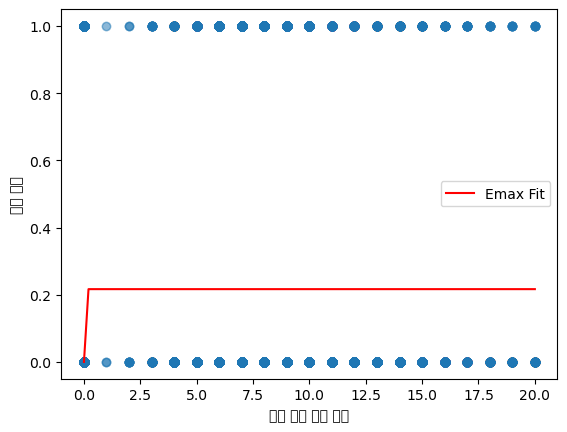

In [5]:
# 📌 Step 0: 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

# 📌 Step 1: 데이터 로드
train = pd.read_csv("C:/Users/yoony/Downloads/open/train.csv").drop(columns=['ID'], errors='ignore')
test = pd.read_csv("C:/Users/yoony/Downloads/open/test.csv").drop(columns=['ID'], errors='ignore')

def feature_engineering(df):
    df = df.copy()
    
    # 숫자로 변환 (에러 발생 시 NaN으로 처리)
    numeric_cols = ["IVF 임신 횟수", "IVF 시술 횟수", "DI 임신 횟수", "DI 시술 횟수", "임신 시도 또는 마지막 임신 경과 연수"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

    
    # 새로운 특징 생성
    # df["IVF 성공률"] = df["IVF 임신 횟수"] / (df["IVF 시술 횟수"] + 1)  : 존재 안함
    # df["DI 성공률"] = df["DI 임신 횟수"] / (df["DI 시술 횟수"] + 1)     : 존재 안함
    df["임신 시도 경과 연수_log"] = np.log1p(df["임신 시도 또는 마지막 임신 경과 연수"])
    
    return df

# 데이터 변환 적용
train = feature_engineering(train)
test = feature_engineering(test)

# 📌 Step 2: Emax 모델 함수 정의
def emax_model(x, emax, ec50, n):
    return emax * (x ** n) / (x ** n + ec50 ** n)

# Emax 모델 적용할 변수 선택 (임신 시도 경과 연수)
x_data = train["임신 시도 또는 마지막 임신 경과 연수"].values
y_data = train["임신 성공 여부"].values

# 결측값 제거 후 Emax 모델 피팅
valid_idx = ~np.isnan(x_data)
x_data = x_data[valid_idx]
y_data = y_data[valid_idx]

popt, _ = curve_fit(emax_model, x_data, y_data, bounds=([0, 0, 0], [1, 100, 10]))

# 📌 Step 3: 피팅 결과 시각화
x_range = np.linspace(min(x_data), max(x_data), 100)
plt.scatter(x_data, y_data, alpha=0.3)
plt.plot(x_range, emax_model(x_range, *popt), color="red", label="Emax Fit")
plt.xlabel("임신 시도 경과 연수")
plt.ylabel("임신 확률")
plt.legend()
plt.show()

In [7]:
# 📌 Step 4: 데이터 전처리
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

# 범주형 변수 리스트
categorical_columns = [
    "시술 시기 코드", "시술 당시 나이", "시술 유형", "특정 시술 유형",
    "배란 자극 여부", "배란 유도 유형", "단일 배아 이식 여부", "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부", "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인",
    "여성 부 불임 원인", "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인",
    "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애", "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증", "불임 원인 - 정자 농도", 
    "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성", "불임 원인 - 정자 형태",
    "배아 생성 주요 이유", "총 시술 횟수", "클리닉 내 총 시술 횟수", "IVF 시술 횟수", 
    "DI 시술 횟수", "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수", "총 출산 횟수",
    "IVF 출산 횟수", "DI 출산 횟수", "난자 출처", "정자 출처", "난자 기증자 나이", 
    "정자 기증자 나이", "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", 
    "대리모 여부", "PGD 시술 여부", "PGS 시술 여부"
]

# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

# Ordinal Encoding 적용
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

# 연속형 변수 결측값 처리
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수", "총 생성 배아 수", "미세주입된 난자 수", 
    "미세주입에서 생성된 배아 수", "이식된 배아 수", "미세주입 배아 이식 수", 
    "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수", "해동 난자 수", 
    "수집된 신선 난자 수", "저장된 신선 난자 수", "혼합된 난자 수", "파트너 정자와 혼합된 난자 수", 
    "기증자 정자와 혼합된 난자 수", "난자 채취 경과일", "난자 해동 경과일", "난자 혼합 경과일", 
    "배아 이식 경과일", "배아 해동 경과일"
]

X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

In [8]:
# 📌 Step 5: 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

In [11]:
# 📌 Step 6: 모델 학습 (ExtraTreesClassifier, LightGBM, RandomForest + Stratified K-Fold)
# LightGBM 모델과 랜덤 포레스트 모델 정의
lgbm_model = lgb.LGBMClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# 각 모델의 성능 기록을 위한 리스트
lgbm_auc_scores = []
rf_auc_scores = []
lgbm_f1_scores = []
rf_f1_scores = []

# X_train_encoded를 DataFrame으로 변환
X_encoded_df = pd.DataFrame(X_train_encoded)

# Stratified K-Fold Cross Validation
for train_idx, val_idx in skf.split(X_encoded_df, y):
    X_train_cv, X_val_cv = X_encoded_df.iloc[train_idx], X_encoded_df.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM 모델 훈련 및 예측
    lgbm_model.fit(X_train_cv, y_train_cv)
    y_pred_val_lgbm = lgbm_model.predict(X_val_cv)
    y_pred_prob_val_lgbm = lgbm_model.predict_proba(X_val_cv)[:, 1]
    
    lgbm_auc_scores.append(roc_auc_score(y_val_cv, y_pred_prob_val_lgbm))
    lgbm_f1_scores.append(f1_score(y_val_cv, y_pred_val_lgbm))
    
    # 랜덤 포레스트 모델 훈련 및 예측
    rf_model.fit(X_train_cv, y_train_cv)
    y_pred_val_rf = rf_model.predict(X_val_cv)
    y_pred_prob_val_rf = rf_model.predict_proba(X_val_cv)[:, 1]
    
    rf_auc_scores.append(roc_auc_score(y_val_cv, y_pred_prob_val_rf))
    rf_f1_scores.append(f1_score(y_val_cv, y_pred_val_rf))

# 성능 출력
print(f"LightGBM AUC-ROC: {np.mean(lgbm_auc_scores):.4f}")
print(f"LightGBM F1-score: {np.mean(lgbm_f1_scores):.4f}")
print(f"Random Forest AUC-ROC: {np.mean(rf_auc_scores):.4f}")
print(f"Random Forest F1-score: {np.mean(rf_f1_scores):.4f}")

# 📌 Step 7: 모델 평가 (ExtraTreesClassifier)
model = ExtraTreesClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

print(f"ExtraTreesClassifier AUC-ROC: {roc_auc_score(y_val, y_pred_prob):.4f}")
print(f"ExtraTreesClassifier F1-score: {f1_score(y_val, y_pred):.4f}")

# 📌 Step 8: 테스트 데이터 예측 및 제출 파일 생성 (세 가지 모델 각각 생성)

# 1. ExtraTreesClassifier 예측
extra_trees_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
extra_trees_submission = pd.read_csv("C:/Users/yoony/Downloads/open/sample_submission.csv")
extra_trees_submission['probability'] = extra_trees_pred_proba
extra_trees_submission.to_csv('C:/Users/yoony/Downloads/open/extra_trees_submit.csv', index=False)

# 2. LightGBM 예측
lgbm_pred_proba = lgbm_model.predict_proba(X_test_encoded)[:, 1]
lgbm_submission = pd.read_csv("C:/Users/yoony/Downloads/open/sample_submission.csv")
lgbm_submission['probability'] = lgbm_pred_proba
lgbm_submission.to_csv('C:/Users/yoony/Downloads/open/lgbm_submit.csv', index=False)

# 3. RandomForest 예측
rf_pred_proba = rf_model.predict_proba(X_test_encoded)[:, 1]
rf_submission = pd.read_csv("C:/Users/yoony/Downloads/open/sample_submission.csv")
rf_submission['probability'] = rf_pred_proba
rf_submission.to_csv('C:/Users/yoony/Downloads/open/rf_submit.csv', index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52982, number of negative: 152098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 205080, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258348 -> initscore=-1.054573
[LightGBM] [Info] Start training from score -1.054573
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52983, number of negative: 152098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force